In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
from scipy.stats import zscore
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path = "./data/"
    
filename = os.path.join(path,"network_intrusion_data.csv")
df = pd.read_csv(filename, na_values=['NA','?'], header=None)
headers = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]
df.columns=headers

In [3]:
binary_convert = lambda x: 0 if x == "normal." else 1
df_binary_array=df['outcome'].apply(binary_convert)
df_binary = pd.DataFrame({'out_binary': df_binary_array})
result = pd.concat([df,df_binary], axis=1, sort=False)
print(result[0:5])

#Label Encoding
le = preprocessing.LabelEncoder()
out_binary = le.fit_transform(result['out_binary'])

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot     ...      dst_host_same_srv_rate  \
0               0       0    0     ...                         1.0   
1               0       0    0     ...                         1.0   
2               0       0    0     ...                         1.0   
3               0       0    0     ...                         1.0   
4               0       0    0     ...                         1.0   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                     0.0                         0.11   
1                     0.0                 

In [4]:
le = preprocessing.LabelEncoder()
result['protocol_type']=le.fit_transform(result['protocol_type'])
result['service'] = le.fit_transform(result['service'])
result['flag'] = le.fit_transform(result['flag'])
result['land'] = le.fit_transform(result['land'])
result['logged_in'] = le.fit_transform(result['logged_in'])
result['root_shell'] = le.fit_transform(result['root_shell'])
result['su_attempted'] = le.fit_transform(result['su_attempted'])
result['is_host_login'] = le.fit_transform(result['is_host_login'])
result['is_guest_login'] = le.fit_transform(result['is_guest_login'])
result=result.drop(columns=['outcome','out_binary'], axis=1)

<h4>Feature Extraction with Univariate Statistical test</h4>

In [5]:
scaler = MinMaxScaler()
X = result.values
X = scaler.fit_transform(X)
Y = out_binary
# feature extraction
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X, Y)
features = fit.transform(X)
# summarize selected features
print("Important feature column indices from X: {}".format(test.get_support(True)))

Important feature column indices from X: [ 1 11 22 23 24 25 30 35 37 38]


<h4>Recursive Feature Elimination</h4>

In [6]:
model = LogisticRegression()
rfe = RFE(model, 10)
fit = rfe.fit(X, Y)

In [7]:
features = fit.transform(X)
print("Selected Features: {}".format(rfe.get_support(True)))

Selected Features: [ 3  7  9 21 22 25 27 28 36 38]


<h4>Feature Importance</h4>

In [8]:
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[3.03246944e-04 1.79933815e-01 2.41693750e-03 1.19515043e-02
 1.12272006e-02 1.11039909e-03 7.25257233e-06 6.95273788e-03
 1.11663259e-05 8.74951083e-03 9.57901820e-05 2.01872404e-03
 5.97901015e-03 1.14023644e-04 6.04362689e-06 5.36702727e-05
 5.62497679e-05 1.45294002e-05 2.15446623e-05 0.00000000e+00
 0.00000000e+00 7.93659060e-04 1.75729361e-01 1.10722860e-01
 1.32858835e-02 1.03040233e-02 1.22518704e-03 2.17629284e-02
 7.51834499e-02 6.28744064e-04 7.91128274e-03 5.61033822e-02
 6.17202429e-02 1.37151122e-02 3.70763495e-03 1.91554191e-01
 3.45579280e-03 3.05580443e-03 1.56531652e-03 3.33037372e-03
 1.32214142e-02]


In [9]:
cnt = 0
dict = {}
for i in model.feature_importances_ :
    dict[i] = cnt
    cnt = cnt + 1

sorted_dictionary = OrderedDict(sorted(dict.items(), key=lambda v: v, reverse=True))
sorted_dictionary

OrderedDict([(0.19155419057977485, 35),
             (0.1799338147410496, 1),
             (0.1757293605717157, 22),
             (0.11072286046571193, 23),
             (0.07518344991044268, 28),
             (0.061720242879195364, 32),
             (0.05610338216894256, 31),
             (0.021762928422020537, 27),
             (0.013715112159391047, 33),
             (0.013285883467924165, 24),
             (0.013221414210051524, 40),
             (0.011951504304826078, 3),
             (0.0112272006164035, 4),
             (0.010304023289950191, 25),
             (0.008749510829620544, 9),
             (0.00791128273952152, 30),
             (0.006952737881705423, 7),
             (0.005979010147729624, 12),
             (0.0037076349515471852, 34),
             (0.0034557927953010508, 36),
             (0.0033303737200800223, 39),
             (0.00305580443369241, 37),
             (0.0024169374994581845, 2),
             (0.0020187240379966886, 11),
             (0.0015653165245

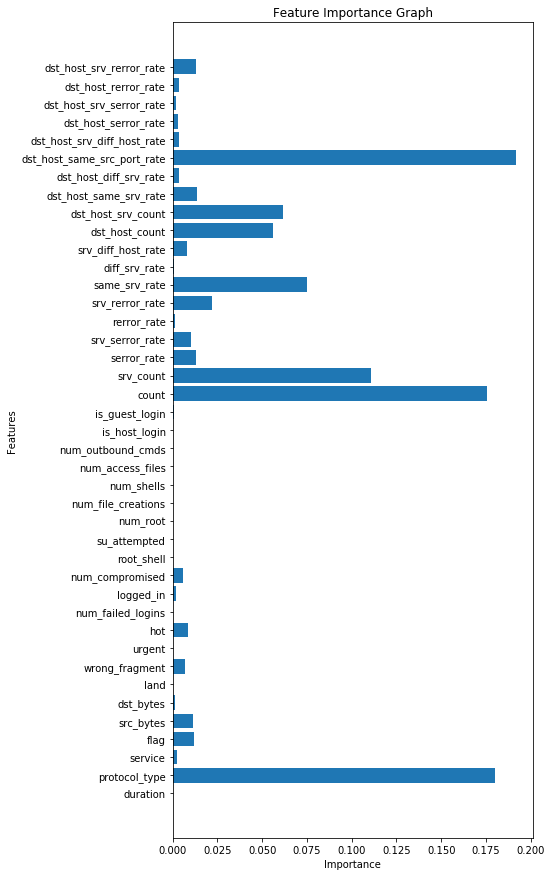

In [10]:
pos = np.arange(41)
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
val = model.feature_importances_
ax.barh(pos, val, align='center')
plt.yticks(pos, headers[:41])
fig.subplots_adjust(left=0.4)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Graph')
plt.show()

In [11]:
result=result.drop(columns=['duration','land','urgent','num_failed_logins','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','rerror_rate'], axis=1)


In [12]:
result[0:5]

,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,count,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,22,9,181,5450,0,0,1,0,8,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,1,22,9,239,486,0,0,1,0,8,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,1,22,9,235,1337,0,0,1,0,8,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,1,22,9,219,1337,0,0,1,0,6,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,1,22,9,217,2032,0,0,1,0,6,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [13]:
df_protocol_type = pd.DataFrame(le.fit_transform(result['protocol_type']), columns=['one_hot_encoded'])
encode_text_dummy(df_protocol_type, 'one_hot_encoded')
one_hot_protocol_type = df_protocol_type.values

df_service = pd.DataFrame(le.fit_transform(result['service']), columns=['one_hot_encoded'])
encode_text_dummy(df_service, 'one_hot_encoded')
one_hot_service = df_service.values

df_flag = pd.DataFrame(le.fit_transform(result['flag']), columns=['one_hot_encoded'])
encode_text_dummy(df_flag, 'one_hot_encoded')
one_hot_flag = df_flag.values

df_logged_in = pd.DataFrame(le.fit_transform(result['logged_in']), columns=['one_hot_encoded'])
encode_text_dummy(df_logged_in, 'one_hot_encoded')
one_hot_logged_in = df_logged_in.values

In [14]:
one_hot_combine = np.concatenate([one_hot_protocol_type, one_hot_service, one_hot_flag, one_hot_logged_in],axis=1)

print(one_hot_combine.shape)

(494021, 82)


In [15]:
df_result=result.copy()

In [16]:
df_result['normalize_src_bytes'] = zscore(df_result['src_bytes'])
df_result['normalize_dst_bytes'] = zscore(df_result['dst_bytes'])
df_result['normalize_wrong_fragment'] = zscore(df_result['wrong_fragment'])

df_result['normalize_hot'] = zscore(df_result['hot'])
df_result['normalize_logged_in'] = zscore(df_result['logged_in'])
df_result['normalize_num_compromised']=zscore(df_result['num_compromised'])

# df_result['normalize_num_outbound_cmds'] = zscore(df_result['num_outbound_cmds']) All values are zero in this so unable for zscore

df_result['normalize_count'] = zscore(df_result['count'])
df_result['normalize_srv_count'] = zscore(df_result['srv_count'])
df_result['normalize_serror_rate'] = zscore(df_result['serror_rate'])

df_result['normalize_srv_serror_rate']=zscore(df_result['srv_serror_rate'])
df_result['normalize_srv_rerror_rate']=zscore(df_result['srv_rerror_rate'])
df_result['normalize_same_srv_rate'] = zscore(df_result['same_srv_rate'])

df_result['normalize_diff_srv_rate'] = zscore(df_result['diff_srv_rate'])
df_result['normalize_srv_diff_host_rate']=zscore(df_result['srv_diff_host_rate'])
df_result['normalize_dst_host_count'] = zscore(df_result['dst_host_count'])

df_result['normalize_dst_host_srv_count'] = zscore(df_result['dst_host_srv_count'])
df_result['normalize_dst_host_same_srv_rate'] = zscore(df_result['dst_host_same_srv_rate'])
df_result['normalize_dst_host_diff_srv_rate'] = zscore(df_result['dst_host_diff_srv_rate'])

df_result['normalize_dst_host_same_src_port_rate'] = zscore(df_result['dst_host_same_src_port_rate'])
df_result['normalize_dst_host_srv_diff_host_rate'] = zscore(df_result['dst_host_srv_diff_host_rate'])
df_result['normalize_dst_host_serror_rate'] = zscore(df_result['dst_host_serror_rate'])

df_result['normalize_dst_host_srv_serror_rate'] = zscore(df_result['dst_host_srv_serror_rate'])
df_result['normalize_dst_host_rerror_rate'] = zscore(df_result['dst_host_rerror_rate'])
df_result['normalize_dst_host_srv_rerror_rate'] = zscore(df_result['dst_host_srv_rerror_rate'])

In [17]:
x2 = df_result['normalize_src_bytes'].values.reshape( len(df_result['src_bytes']),1)
x3 = df_result['normalize_dst_bytes'].values.reshape( len(df_result['dst_bytes']),1)
x4 = df_result['normalize_wrong_fragment'].values.reshape( len(df_result['wrong_fragment']),1)

x6 = df_result['normalize_hot'].values.reshape( len(df_result['hot']),1)
x8 = df_result['normalize_logged_in'].values.reshape( len(df_result['logged_in']),1)
x9 = df_result['normalize_num_compromised'].values.reshape( len(df_result['num_compromised']),1)

x14 = df_result['normalize_count'].values.reshape( len(df_result['count']),1)
x15 = df_result['normalize_srv_count'].values.reshape( len(df_result['srv_count']),1)
x16 = df_result['normalize_serror_rate'].values.reshape( len(df_result['serror_rate']),1)

x17 = df_result['normalize_srv_serror_rate'].values.reshape( len(df_result['srv_serror_rate']),1)
x19 = df_result['normalize_srv_rerror_rate'].values.reshape( len(df_result['srv_rerror_rate']),1)
x20 = df_result['normalize_same_srv_rate'].values.reshape( len(df_result['same_srv_rate']),1)

x21 = df_result['normalize_diff_srv_rate'].values.reshape( len(df_result['diff_srv_rate']),1)
x22 = df_result['normalize_srv_diff_host_rate'].values.reshape( len(df_result['srv_diff_host_rate']),1)
x23 = df_result['normalize_dst_host_count'].values.reshape( len(df_result['dst_host_count']),1)

x24 = df_result['normalize_dst_host_srv_count'].values.reshape( len(df_result['dst_host_srv_count']),1)
x25 = df_result['normalize_dst_host_same_srv_rate'].values.reshape( len(df_result['dst_host_same_srv_rate']),1)
x26 = df_result['normalize_dst_host_diff_srv_rate'].values.reshape( len(df_result['dst_host_diff_srv_rate']),1)

x27 = df_result['normalize_dst_host_same_src_port_rate'].values.reshape( len(df_result['dst_host_same_src_port_rate']),1)
x28 = df_result['normalize_dst_host_srv_diff_host_rate'].values.reshape( len(df_result['dst_host_srv_diff_host_rate']),1)
x29 = df_result['normalize_dst_host_serror_rate'].values.reshape( len(df_result['dst_host_serror_rate']),1)

x30 = df_result['normalize_dst_host_srv_serror_rate'].values.reshape( len(df_result['dst_host_srv_serror_rate']),1)
x31 = df_result['normalize_dst_host_rerror_rate'].values.reshape( len(df_result['dst_host_rerror_rate']),1)
x32 = df_result['normalize_dst_host_srv_rerror_rate'].values.reshape( len(df_result['dst_host_srv_rerror_rate']),1)

In [18]:
print(out_binary[0:5])

[0 0 0 0 0]


<h4>Applying Logistic regression</h4>

In [19]:
x = np.concatenate([one_hot_combine,x2,x3,x4,x6,x8,x9,x14,x15,x16,x17,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32],axis=1)
y=df_binary['out_binary']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42)
print(x.shape)
print(y.shape)


(494021, 106)
(494021,)


In [21]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
Log_pred=logreg.predict(x_test)

# Measure accuracy
score = metrics.accuracy_score(y_test, Log_pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.99470674561004


<h4>Confusion Matrix: Logistic Regression</h4>

[[19227   126]
 [  397 79055]]
Plotting confusion matrix


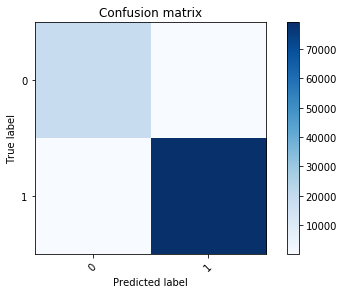

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     19353
          1       1.00      1.00      1.00     79452

avg / total       0.99      0.99      0.99     98805

Precision : 0.99470674561004
Recall : 0.9950032724160499
F1 Score : 0.9967030819564656


In [22]:
# Compute confusion matrix

cm = confusion_matrix(y_test, Log_pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, logreg.classes_)
plt.show()

print(classification_report(y_test, Log_pred))
print("Precision :", metrics.accuracy_score(y_test, Log_pred))
print("Recall :", metrics.recall_score(y_test, Log_pred))
print("F1 Score :", metrics.f1_score(y_test, Log_pred))

<h4>ROC Curve: Logistic Regression</h4>

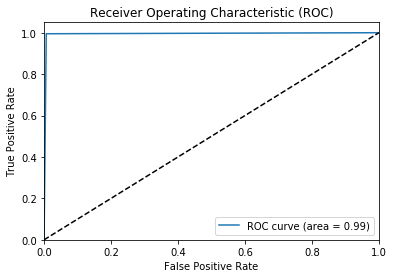

In [23]:
# Plot an ROC. pred - the predictions, y - the expected output.
plot_roc(Log_pred,y_test)